In [ ]:
# # 这里是爬取视觉中国里喀纳斯的图片，因为视觉中国里的图片比较纯净
# from urllib import request
# import os
# import re  # 正则表达式库


# # 输入类别名称,子类别名称，文件名，输出图片路径
# def get_path(classname, filename):
#     # 获取当前工作路径
#     cwd = os.getcwd()
#     # 获取图像的保存目录
#     dir_path = cwd + '/vcg_test/' + classname
#     # 目录是否存在,不存在则创建目录
#     if os.path.exists(dir_path):
#         pass
#     else:
#         os.makedirs(dir_path)
#     # 获取图像的绝对路径
#     file_path = dir_path + '/' + filename
#     return file_path


# classnames = ['kanasi','yilihegu']
# keypoints = ['%E5%96%80%E7%BA%B3%E6%96%AF']  # 关键字对应
# all_page = 35  # 想要下载的总页数,其中每页与检索相同,为100张
# for class_index, phrase in enumerate(classnames):
#     sum_all_num = 0
#     if class_index >= 0:  # 从某一类断开则选择该类为起始点
#         for page in range(1, all_page + 1):
#             num_in_page = 1
#             # 获得url链接,这里额外增加了筛选条件:图片中仅有一个人
#             url = 'https://www.vcg.com/creative/search?phrase=' + keypoints[
#                 class_index] + '&graphicalStyle=1&page=' + str(page)
#             header = {
#                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.81 Safari/537.36',
#                 #                'User-Agent':'Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6'
#             }
#             req = request.Request(url=url, headers=header)
#             openhtml = request.urlopen(req).read().decode('utf8')

#             # 正则表达式
#             com = re.compile('"url800":.*?/creative/.*?.jpg"')

#             # 匹配URl地址
#             urladds = com.findall(openhtml)
#             for urladd in urladds:
#                 # try ... except防止匹配出错后程序停止
#                 try:
#                     add = 'http:' + urladd.strip('"url800":')
#                     # 获取文件名称,格式:vcg+性别+获取方式+page+page中的第几张图片，vcg_raw代表原vcg网站对性别分类
#                     filename = classnames[class_index] + '_'  + '_vcg_raw_page' + str(page) + '_' + str(num_in_page) + '.jpg'
#                     path = get_path(classnames[class_index], filename)
#                     print('当前下载...', filename)

#                     dom = request.urlopen(add).read()
#                     with open(path, 'wb') as f:
#                         f.write(dom)
#                         sum_all_num += 1
#                         num_in_page += 1
#                 except:
#                     print('当前该任务总共总共下载:', sum_all_num)  # 监控进度
#                 if sum_all_num % 50 == 0:  # 监控进度
#                     print('当前该任务总共下载:', sum_all_num)

# Paddle2.0-通过DCGAN实现人脸图像生成

本教程将通过一个示例对DCGAN进行介绍。在向其展示许多真实人脸照片（数据集：[Celeb-A Face](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)）后，我们将训练一个生成对抗网络（GAN）来产生新人脸。本文将对该实现进行详尽的解释，并阐明此模型的工作方式和原因。并不需要过多专业知识，但是可能需要新手花一些时间来理解的模型训练的实际情况。为了节省时间，请尽量选择GPU进行训练。


## 1 简介
本项目基于paddlepaddle，结合生成对抗网络（DCGAN）,通过弱监督学习的方式，训练生成真实人脸照片

### 1.1 什么是GAN？

生成对抗网络（Generative Adversarial Network [1]，简称GAN）是非监督式学习的一种方法，通过让两个神经网络相互博弈的方式进行学习。该方法最初由 lan·Goodfellow 等人于2014年提出，原论文见 [Generative Adversarial Network](https://arxiv.org/abs/1406.2661)。

  生成对抗网络由一个生成网络与一个判别网络组成。生成网络从潜在空间（latent space）中随机采样作为输入，其输出结果需要尽量模仿训练集中的真实样本。判别网络的输入为真实样本或生成网络的输出，其目的是将生成网络的输出从真实样本中尽可能分辨出来。而生成网络则要尽可能地欺骗判别网络。两个网络相互对抗、不断调整参数，其目的是将生成网络生成的样本和真实样本尽可能的区分开[2] ）。 
  
让$x$是代表图像的数据。$D(x)$是判别器网络，输出的概率为$x$来自训练数据还是生成器。在这里输入$D(x)$的$x$是CHW大小为3x128x128的图像。使得$x$来自训练数据时$D(x)$尽量接近1，$x$来自生成器时$D(x)$尽量接近0。$D(x)$也可以被认为是传统的二进制分类器。

对于生成器网络，$z$为从标准正态分布采样的潜在空间向量。$G(z)$表示生成器函数，该函数将矢量$z$映射到数据空间。生成器的目标是拟合训练数据($p_{data}$)的分布，以便可以从该估计分布中生成假样本($p_g$)。

所以，$D(G(z))$是生成器$G$输出是真实的图像的概率。如Goodfellow的论文所述，$D$和$G$玩一个minimax游戏，其中$D$尝试最大化其正确分类真假的可能性$logD(x)$，以及$G$试图最小化以下可能性$D$会预测其输出是假的$log(1-D(G(x)))$。

GAN的损失函数可表示为：

> $\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$

从理论上讲，此minimax游戏的解决方案是$p_g = p_{data}$，鉴别者会盲目猜测输入是真实的还是假的。但是，GAN的收敛理论仍在积极研究中，实际上GAN常常会遇到梯度消失/爆炸问题。  
生成对抗网络常用于生成以假乱真的图片。此外，该方法还被用于生成视频、三维物体模型等。


### 1.2 什么是DCGAN？

DCGAN是深层卷积网络与 GAN 的结合，其基本原理与 GAN 相同，只是将生成网络和判别网络用两个卷积网络（CNN）替代。为了提高生成样本的质量和网络的收敛速度，论文中的 DCGAN 在网络结构上进行了一些改进：

 * 取消 pooling 层：在网络中，所有的pooling层使用步幅卷积（strided convolutions）(判别器)和微步幅度卷积（fractional-strided convolutions）(生成器)进行替换。
 * 加入 batch normalization：在生成器和判别器中均加入batchnorm。
 * 使用全卷积网络：去掉了FC层，以实现更深的网络结构。
 * 激活函数：在生成器（G）中，最后一层使用Tanh函数，其余层采用 ReLu 函数 ; 判别器（D）中都采用LeakyReLu。  

  ### 1.3 本文的改进
         
   * 将Adam优化器beta1参数设置为0.8，具体请参考[原论文](https://arxiv.org/abs/1412.6980)
   * 将BatchNorm批归一化中momentum参数设置为0.5
   * 将判别器(D)激活函数由elu改为leaky_relu，并将alpha参数设置为0.2
   * 生成器输出，判别器输入改为[3,128,128]
   * 损失函数选用Softmax_with_cross_entropy
   ---
 

## 2 环境设置及数据集


### 2.1 数据集预处理
多线程处理，以裁切坐标(0,0)和(512,512)，将输入网络的图片裁切到512*512.

In [ ]:
# !unzip -oq /home/aistudio/data/data88945/喀纳斯图片.zip 

In [ ]:
# !mv 喀纳斯图片 kanasi

In [ ]:
!unzip -oq /home/aistudio/kanasi.zip 

In [ ]:
from PIL import Image
import os.path
import os
import threading
import paddle
from PIL import ImageFile
print(paddle.__version__)
ImageFile.LOAD_TRUNCATED_IMAGES = True

'''多线程将图片缩放后再裁切到512*512分辨率'''
#裁切图片宽度
# w = 512
#裁切图片高度
# h = 512
w = 64
h = 64
#裁切点横坐标(以图片左上角为原点)
x = 0
#裁切点纵坐标
y = 0

def cutArray(l, num):
  avg = len(l) / float(num)
  o = []
  last = 0.0

  while last < len(l):
    o.append(l[int(last):int(last + avg)])
    last += avg

  return o
  
def convertjpg(jpgfile,outdir,width=w,height=h):
    img=Image.open(jpgfile)
    (l,h) = img.size
    rate = min(l,h) / width
    try:
        img = img.resize((int(l // rate),int(h // rate)),Image.BILINEAR)
        img = img.crop((x,y,width+x,height+y))
        img.save(os.path.join(outdir,os.path.basename(jpgfile)))
    except Exception as e:
        print(e)

class thread(threading.Thread):
    def __init__(self, threadID, inpath, outpath, files):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.inpath = inpath
        self.outpath = outpath
        self.files = files
    def run(self):
        count = 0
        try:
            for file in self.files:
                convertjpg(self.inpath + file,self.outpath)
                count = count + 1
        except Exception as e:
            print(e)
        print('已处理图片数量：' +  str(count))
            
if __name__ == '__main__':
    inpath = '/home/aistudio/kanasi/'
    outpath = '/home/aistudio/work/imgs/'
    if not os.path.exists(outpath):
        os.mkdir(outpath)
    files =  os.listdir(inpath)
    files = cutArray(files,8)
    T1 = thread(1, inpath, outpath, files[0])
    T2 = thread(2, inpath, outpath, files[1])
    T3 = thread(3, inpath, outpath, files[2])
    T4 = thread(4, inpath, outpath, files[3])
    T5 = thread(5, inpath, outpath, files[4])
    T6 = thread(6, inpath, outpath, files[5])
    T7 = thread(7, inpath, outpath, files[6])
    T8 = thread(8, inpath, outpath, files[7])
    
    T1.start()
    T2.start()
    T3.start()
    T4.start()
    T5.start()
    T6.start()
    T7.start()
    T8.start()
    
    T1.join()
    T2.join()
    T3.join()
    T4.join()
    T5.join()
    T6.join()
    T7.join()
    T8.join()


## 3 模型组网
### 3.1 定义数据预处理工具-Paddle.io.Dataset
具体参考[Paddle.io.Dataset教程](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc/api/paddle/io/Dataset_cn.html#dataset)

In [ ]:
import os
import cv2
import numpy as np
# from skimage import io,color,transform
import matplotlib.pyplot as plt
import math
import time
import paddle
from paddle.io import Dataset
import six
from PIL import Image 
import paddle.fluid as fluid
from paddle.static import InputSpec
paddle.enable_static()
# img_dim = 512
img_dim = 64


'''准备数据，定义Reader()'''
PATH = '/home/aistudio/work/imgs/'

class DataGenerater(Dataset):
    """
    数据集定义
    """
    def __init__(self,path=PATH):
        """
        构造函数
        """
        super(DataGenerater, self).__init__()
        self.dir = path
        self.datalist = os.listdir(PATH)
        self.image_size = (img_dim,img_dim)
    
    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return self._load_img(self.dir + self.datalist[idx])

    # 返回整个数据集的总数
    def __len__(self):
        return len(self.datalist)
    
    def _load_img(self, path):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        try:
            img = cv2.imread(path)
            img = cv2.resize(img,self.image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img_norm = np.zeros(img.shape)
            # img = cv2.normalize(img, dst=img_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            img = np.array(img).astype('float32') # 转换成数组类型浮点型32位
            img = img.transpose() # 矩阵转置
            # print(img)
            img = img/255.0
        except Exception as e:
                print(e)
        return img

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


(64, 64, 3)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


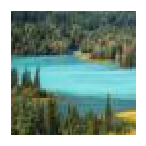

In [ ]:
# CV2读入图片后为BGR模式，而plt画图则是RGB模式，这就导致图片颜色发生很大变化
# 故采用cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)将读入的BGR图片转换为RGB图片
img_BGR = cv2.imread("/home/aistudio/work/imgs/kanasi_female_vcg_raw_page4_30.jpg")
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
# p = Image.open("work/imgs/kanasi_female_vcg_raw_page4_30.jpg")
print(img_RGB.shape)
image = np.array(img_RGB)
plt.figure(figsize=(25,25))
plt.subplot(10, 10,  1)
plt.imshow(image, vmin=-1, vmax=1)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
plt.close()

### 3.2 测试Paddle.io.DataLoader并输出图片

In [8]:
train_dataset = DataGenerater()
imgs = paddle.static.data(name='img', shape=[None,3,img_dim,img_dim], dtype='float32')
print(imgs)

var img : paddle.VarType.LOD_TENSOR.shape(-1, 3, 64, 64).astype(VarType.FP32)


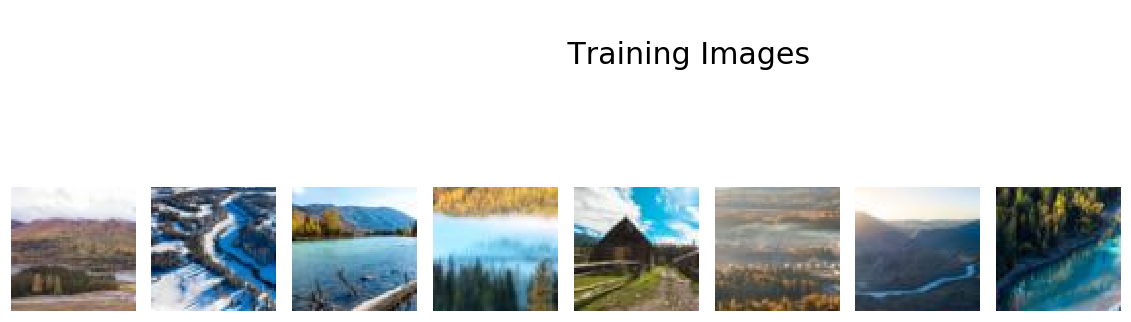

In [9]:
train_loader = paddle.io.DataLoader(
    train_dataset, 
    places=paddle.CPUPlace(), 
    feed_list = [imgs],
    batch_size=32, 
    shuffle=True,
    num_workers=2,
    use_buffer_reader=True,
    use_shared_memory=False,
    # drop_last (bool) - 是否丢弃因数据集样本数不能被 batch_size 整除而产生的最后一个不完整的mini-batch，为 batch_sampler 的替代参数
    drop_last=True,
    )

for batch_id, data in enumerate(train_loader()):
    plt.figure(figsize=(25,25))
    try:
        for i in range(8):
            # 1,3,512,512 -> 512,512,3
            image = np.array(data[0][i])[0].transpose((2,1,0))
            plt.subplot(10, 10, i + 1)
            plt.imshow(image, vmin=-1, vmax=1)
            plt.axis('off')
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.suptitle('\n Training Images',fontsize=30)
        plt.show()
        break
    except IOError:
        print(IOError)


### 3.3 权重初始化
在 DCGAN 论文中，作者指定所有模型权重应从均值为0、标准差为0.02的正态分布中随机初始化。  
在paddle.nn中，调用fluid.nn.initializer.Normal实现initialize设置

In [10]:
conv_initializer=paddle.nn.initializer.Normal(mean=0.0, std=0.02)
bn_initializer=paddle.nn.initializer.Normal(mean=1.0, std=0.02)


### 3.4 判别器
如上文所述，生成器$D$是一个二进制分类网络，它以图像作为输入，输出图像是真实的（相对应$G$生成的假样本）的概率。输入$Shape$为[3,512,512]的RGB图像，通过一系列的$Conv2d$，$BatchNorm2d$和$LeakyReLU$层对其进行处理，然后通过全连接层输出的神经元个数为2，对应两个标签的预测概率。

* 将BatchNorm批归一化中momentum参数设置为0.5
* 将判别器(D)激活函数leaky_relu的alpha参数设置为0.2

> 输入:  为大小512*512的RGB三通道图片  
> 输出:  经过一层全连接层最后为shape为[batch_size,2]的Tensor

In [11]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

class Discriminator(paddle.nn.Layer):
    def __init__(self):
        super(Discriminator, self).__init__()
        # class paddle.nn.Conv2D(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', weight_attr=None, bias_attr=None, data_format='NCHW')
        # 在判别器中第一层卷积和第二层卷积之间不需要用batchNorm
        # 3*512*512
        self.conv_1 = nn.Conv2D(
            3,64,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_1_",initializer=conv_initializer)
            )
        # 64*256*256
        self.conv_2 = nn.Conv2D(
            64,128,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_2_",initializer=conv_initializer)
            )
        self.bn_2 = nn.BatchNorm2D(
            128,
            weight_attr=paddle.ParamAttr(name="d_2_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 128*128*128
        self.conv_3 = nn.Conv2D(
            128,256,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_3_",initializer=conv_initializer)
            )
        self.bn_3 = nn.BatchNorm2D(
            256,
            weight_attr=paddle.ParamAttr(name="d_3_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 256*64*64
        self.conv_4 = nn.Conv2D(
            256,512,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_4_",initializer=conv_initializer)
            )
        self.bn_4 = nn.BatchNorm2D(
            512,
            weight_attr=paddle.ParamAttr(name="d_4_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        self.conv_5 = nn.Conv2D(
            512,1,4,1,0,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_5_",initializer=conv_initializer)
        )
        # 1*1*1
    
    def forward(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_5(x)
        return x

### 3.5 生成器
生成器$G$旨在映射潜在空间矢量$z$到数据空间。由于我们的数据是图像，因此转换$z$到数据空间意味着最终创建具有与训练图像相同大小[3,512,512]的RGB图像。在网络设计中，这是通过一系列二维卷积转置层来完成的，每个层都与$BatchNorm$层和$ReLu$激活函数。生成器的输出通过$tanh$函数输出，以使其返回到输入数据范围[−1,1]。值得注意的是，在卷积转置层之后存在$BatchNorm$函数，因为这是DCGAN论文的关键改进。这些层有助于训练过程中的梯度更好地流动。  

* 将$BatchNorm$批归一化中$momentum$参数设置为0.5

> 输入:Tensor的Shape为[batch_size,100]其中每个数值大小为0~1之间的float32随机数  
> 输出:3x512*512RGB三通道图片


In [12]:
class Generator(paddle.nn.Layer):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv_1 = nn.Conv2DTranspose(
            100,512,4,1,0,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_1_",initializer=conv_initializer)
            )
        self.bn_1 = nn.BatchNorm2D(
            512,
            weight_attr=paddle.ParamAttr(name="g_1_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 512 * 32 * 32
        self.conv_2 = nn.Conv2DTranspose(
            512,256,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_2_",initializer=conv_initializer)
            )
        self.bn_2 = nn.BatchNorm2D(
            256,
            weight_attr=paddle.ParamAttr(name="g_2_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 256 * 64 * 64
        self.conv_3 = nn.Conv2DTranspose(
            256,128,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_3_",initializer=conv_initializer)
            )
        self.bn_3 = nn.BatchNorm2D(
            128,
            weight_attr=paddle.ParamAttr(name="g_3_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 128 * 128 * 128
        self.conv_4 = nn.Conv2DTranspose(
            128,64,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_4_",initializer=conv_initializer)
            )
        self.bn_4 = nn.BatchNorm2D(
            64,
            weight_attr=paddle.ParamAttr(name="g_4_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 64 * 256 * 256
        self.conv_5 = nn.Conv2DTranspose(
            64,3,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_5_",initializer=conv_initializer)
            )
        # 3 * 64 * 64
        self.tanh = paddle.nn.Tanh()
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        x = self.conv_5(x)
        x = self.tanh(x)
        return x

### 3.6 损失函数
选用BCELoss,公式如下:

  $Out = -1 * (label * log(input) + (1 - label) * log(1 - input))$
 

In [13]:
###损失函数
# loss = paddle.nn.BCELoss()
# 改为
loss = paddle.nn.MSELoss()

## 4 模型训练
 设置的超参数为：
 * 学习率：0.0002
 * 输入图片长和宽：512
 * Epoch: 500
 * Mini-Batch：8
 * 输入Tensor长度：100
 * Adam：Beta1：0.5，Beta2：0.999  
 
训练过程中的每一次迭代，生成器和判别器分别设置自己的迭代次数。为了避免判别器快速收敛到0，本教程默认每迭代一次，训练一次判别器，两次生成器。

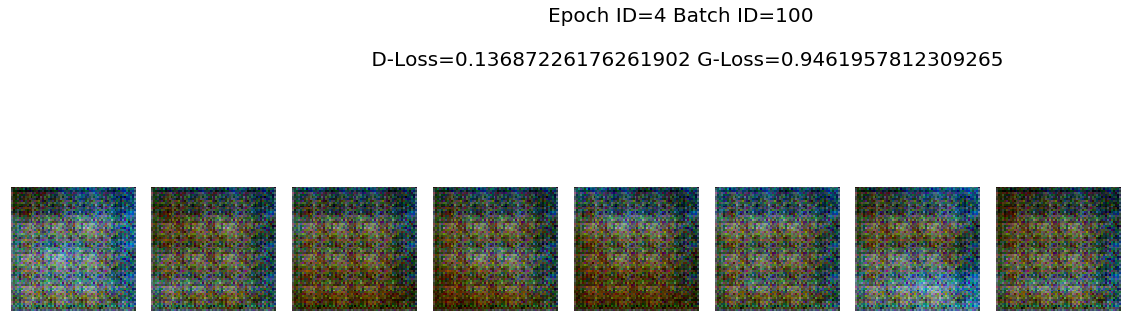

In [14]:
import IPython.display as display
import warnings
import paddle.optimizer as optim
warnings.filterwarnings('ignore')

# img_dim = 512
img_dim = 64
lr = 0.0002
epoch = 500
output = "work/Output/"
batch_size = 32
G_DIMENSION = 100
beta1=0.5
beta2=0.999
output_path = 'work/Output'
device = paddle.set_device('gpu')
paddle.disable_static(device)

real_label = 1.
fake_label = 0.

netD = Discriminator()
netG = Generator()
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2)

###训练过程
losses = [[], []]
#plt.ion()
now = 0
for pass_id in range(epoch):
    # enumerate()函数将一个可遍历的数据对象组合成一个序列列表
    for batch_id, data in enumerate(train_loader()):
        #训练判别器 
        optimizerD.clear_grad()
        real_cpu = data[0]
        label = paddle.full((batch_size,1,1,1),real_label,dtype='float32')
        output = netD(real_cpu)
        errD_real = loss(output,label)
        errD_real.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        noise = paddle.randn([batch_size,G_DIMENSION,1,1],'float32')
        fake = netG(noise)
        label = paddle.full((batch_size,1,1,1),fake_label,dtype='float32')
        output = netD(fake.detach())
        errD_fake = loss(output,label)
        errD_fake.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        errD = errD_real + errD_fake
        
        losses[0].append(errD.numpy()[0])
        ###训练生成器
        optimizerG.clear_grad()
        noise = paddle.randn([batch_size,G_DIMENSION,1,1],'float32')
        fake = netG(noise)
        label = paddle.full((batch_size,1,1,1),real_label,dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()

        
        losses[1].append(errG.numpy()[0])
        if batch_id % 100 == 0:
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            # 每轮的生成结果
            generated_image = netG(noise).numpy()
            imgs = []
            plt.figure(figsize=(25,25))
            try:
                for i in range(8):
                    image = generated_image[i].transpose()
                    image = np.where(image > 0, image, 0)
                    plt.subplot(10, 10, i + 1)
                    plt.imshow(image, vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id, batch_id, errD.numpy()[0], errG.numpy()[0])
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format(output_path, pass_id, batch_id),bbox_inches='tight')
                plt.pause(0.01)
                display.clear_output(wait=True)
            except IOError:

                print(IOError)
    # print("epoch:{}/{}".format(pass_id,epoch))

paddle.save(netG.state_dict(), "/home/aistudio/work/generator.params")

plt.close()


In [ ]:
plt.figure(figsize=(15, 6))
x = np.arange(len(losses[0]))
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Number of Batch')
plt.plot(x,np.array(losses[0]),label='D Loss')
plt.plot(x,np.array(losses[1]),label='G Loss')
plt.legend()
plt.savefig('/home/aistudio/work/Generator and Discriminator Loss During Training.png')
plt.show()

## 6 模型预测
### 输入随机数让生成器$G$生成随机人脸
生成的RGB三通道64*64的图片路径位于“worl/Generate/”

In [ ]:
device = paddle.set_device('gpu')
paddle.disable_static(device)
try:
    # generate = Generator()
    # state_dict = paddle.load("/home/aistudio/work/generator.params")
    # generate.set_state_dict(state_dict)
    noise = paddle.randn([100,100,1,1],'float32')
    # generated_image = generate(noise).numpy()
    generated_image = netG(noise).numpy()
    for j in range(8):
        image = generated_image[j].transpose()
        # image = (image * 255.0).astype('uint8')
        # print(type(image))
        plt.figure(figsize=(5,5))
        plt.imshow(image)
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.savefig('/home/aistudio/work/Generate/generated_' + str(j + 1), bbox_inches='tight')
        plt.pause(0.01)
        plt.close()
except IOError:
    print(IOError)

